## Setting up environment with initial parameters

In [1]:
import numpy as np
import pandas as pd
import csv
import pyarrow as pa
import pyarrow.parquet as pq
import math
import matplotlib.pyplot as plt
import time
import warnings

In [2]:
# Setting up initial arguments
cm_file_path = "output/confusion_matrix.parquet"

## Loading confusion matrix combinations from file

In [3]:
def load_parquet_confusion_matrix(file_path):
    return pd.read_parquet(file_path, engine='pyarrow')

In [4]:
# Loading data from parquet file
cm_df = load_parquet_confusion_matrix(cm_file_path)

print(f"Shape of DataFrame: {cm_df.shape}")
print(cm_df.head())

Shape of DataFrame: (6724520, 8)
   0  1  2  3  4  5  6   7
0  0  0  0  0  0  0  0  28
1  0  0  0  0  0  0  1  27
2  0  0  0  0  0  0  2  26
3  0  0  0  0  0  0  3  25
4  0  0  0  0  0  0  4  24


## Kullback-Leibler Divergence

In [5]:
# {TPp, FNp, FPp, TNp, TPup, FNup, FPup, TNup}
def kullback_leibler_divergence_row(row):
    P = np.array([(row[0] + row[2]) / (row[0] + row[1] + row[2] + row[3]),
                  (row[1] + row[3]) / (row[0] + row[1] + row[2] + row[3])])
    Q = np.array([(row[4] + row[6]) / (row[4] + row[5] + row[6] + row[7]),
                  (row[5] + row[7]) / (row[4] + row[5] + row[6] + row[7])])
    
    kld = np.sum(P * np.log(P / Q))
    
    return kld

In [6]:
# Calculating kullback leibler divergence
# Turn off warnings becouse of division by 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cm_df['kld'] = cm_df.apply(kullback_leibler_divergence_row, axis=1)

## Vizualizations for KLD

Number of NaN values: 474614
Number of inf values: 447876


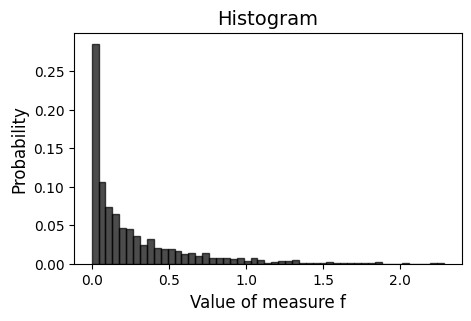

In [7]:
# NaN values handling
kld_nan = cm_df['kld'].isna().sum()
cm_df['kld'].dropna(inplace=True)
print(f"Number of NaN values: {kld_nan}")

# Inf values handling
kld_inf = np.isinf(cm_df['kld']).sum()
cm_df = cm_df[~np.isinf(cm_df['kld'])]
print(f"Number of inf values: {kld_inf}")

weights = np.ones_like(cm_df['kld']) / len(cm_df['kld'])

plt.figure(figsize=(5, 3))
plt.hist(cm_df['kld'], bins=51, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

In [8]:
# Print confusion matrix with maximum KLD value
print(cm_df.loc[cm_df['kld'].idxmax()])

0       0.000000
1       0.000000
2       1.000000
3       9.000000
4       0.000000
5       0.000000
6      17.000000
7       1.000000
kld     2.281967
Name: 60127, dtype: float64


# Calculating IR and GR

In [9]:
def get_imbalance_ratio(df):
    return (df[0] + df[1] + df[4] + df[5]) / (df[0] + df[1] + df[2] + df[3] + df[4] + df[5] + df[6] + df[7])

In [10]:
def get_group_ratio(df):
    return (df[0] + df[1] + df[2] + df[3]) / (df[0] + df[1] + df[2] + df[3] + df[4] + df[5] + df[6] + df[7])

In [11]:
cm_df['IR'] = get_imbalance_ratio(cm_df)
cm_df['GR'] = get_group_ratio(cm_df)
cm_df

,0,1,2,3,4,5,6,7,kld,IR,GR
0,0,0,0,0,0,0,0,28,NaN,0.000000,0.000000
1,0,0,0,0,0,0,1,27,NaN,0.000000,0.000000
2,0,0,0,0,0,0,2,26,NaN,0.000000,0.000000
3,0,0,0,0,0,0,3,25,NaN,0.000000,0.000000
4,0,0,0,0,0,0,4,24,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6724515,27,0,0,0,1,0,0,0,NaN,1.000000,0.964286
6724516,27,0,0,1,0,0,0,0,NaN,0.964286,1.000000
6724517,27,0,1,0,0,0,0,0,NaN,0.964286,1.000000
6724518,27,1,0,0,0,0,0,0,NaN,1.000000,1.000000


## KLD  for specific IR (GR = 1/2)

In [12]:
# KLD for IR = 27/28 and GR = 1/2 
kld_selected = cm_df.loc[(cm_df['IR'] == 27/28) & (cm_df['GR'] == 1/2), ['kld']]

print(f"Total rows selected: {len(kld_selected)}, Rows with NaN values: {kld_selected['kld'].isna().sum()}")

Total rows selected: 762, Rows with NaN values: 86


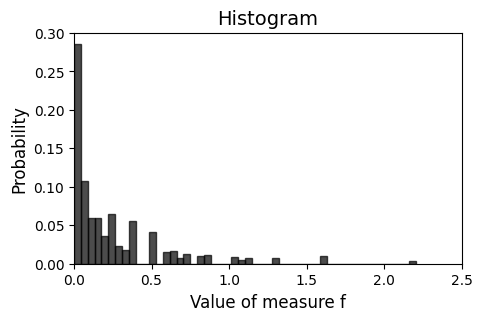

In [20]:
# Histogram of KLD values for IR = 27/28 and GR = 1/2
weights = np.ones_like(kld_selected) / len(kld_selected)

plt.figure(figsize=(5, 3))
plt.hist(kld_selected, bins=50, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.xlim(0, 2.5)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

In [14]:
# KLD for IR = 21/28 and GR = 1/2 
kld_selected = cm_df.loc[(cm_df['IR'] == 21/28) & (cm_df['GR'] == 1/2), ['kld']]

print(f"Total rows selected: {len(kld_selected)}, Rows with NaN values: {kld_selected['kld'].isna().sum()}")

Total rows selected: 14696, Rows with NaN values: 744


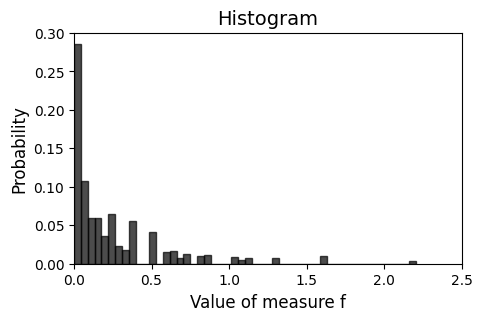

In [21]:
# Histogram of KLD values for IR = 21/28 and GR = 1/2
weights = np.ones_like(kld_selected) / len(kld_selected)

plt.figure(figsize=(5, 3))
plt.hist(kld_selected, bins=50, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.xlim(0, 2.5)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

## KLD for specific GR (IR = 1/2)

In [16]:
# KLD for IR = 1/2 and GR = 21/28
kld_selected = cm_df.loc[(cm_df['IR'] == 1/2) & (cm_df['GR'] == 21/28), ['kld']]

print(f"Total rows selected: {len(kld_selected)}, Rows with NaN values: {kld_selected['kld'].isna().sum()}")

Total rows selected: 13408, Rows with NaN values: 240


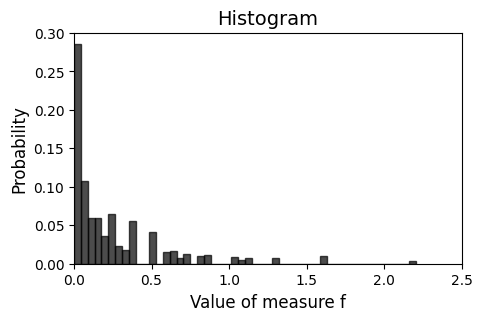

In [22]:
# Histogram of KLD values for IR = 1/2 and GR = 21/28
weights = np.ones_like(kld_selected) / len(kld_selected)

plt.figure(figsize=(5, 3))
plt.hist(kld_selected, bins=50, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.xlim(0, 2.5)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

In [18]:
# KLD for IR = 1/2 and GR = 7/28
kld_selected = cm_df.loc[(cm_df['IR'] == 1/2) & (cm_df['GR'] == 7/28), ['kld']]

print(f"Total rows selected: {len(kld_selected)}, Rows with NaN values: {kld_selected['kld'].isna().sum()}")

Total rows selected: 15200, Rows with NaN values: 2032


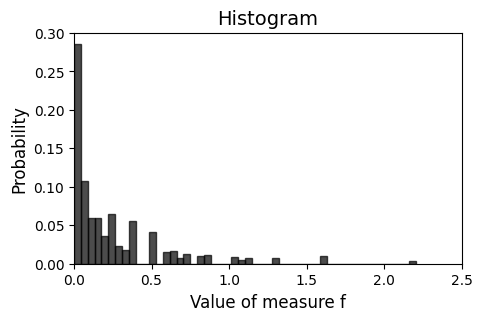

In [23]:
# Histogram of KLD values for IR = 1/2 and GR = 7/28
weights = np.ones_like(kld_selected) / len(kld_selected)

plt.figure(figsize=(5, 3))
plt.hist(kld_selected, bins=50, color='black', edgecolor='black', alpha=0.7, weights=weights)
plt.xlim(0, 2.5)
plt.title("Histogram", fontsize=14)
plt.xlabel("Value of measure f", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

## Memory realese

In [ ]:
del cm_df